# CNN Histopathologic Cancer Detection 

## Overview
This notebook is a practice of utilizing the TensorFlow and Keras to build a Convolutional Neural Network (CNN) for predicting cancer detection from digital pathology images. The practice is based on a Kaggle competition, and the data can be obtained from the competition website at https://www.kaggle.com/competitions/histopathologic-cancer-detection/data.

This notebook can also be found at https://github.com/Lorby04/msds/tree/main/dl/week3 and https://www.kaggle.com/code/lorbybi/cnn-histopathologic-cancer-detection

1. Data preparing

Downloading data from the source, extract the compressed files to local disk.
The original image is in tiff format which is not supported by tensorflow. Although there's other packages can handle the format, but it requires mandy dependecies which makes the image loading tasks being complex. To simplify the procedure, finally I converted the tiff image to jpeg format with the package Pillow. 
After the images are prepared, I'm planning to use the Keras API "image_dataset_from_directory()" to create tensorflow dataset from the directory. The API requires the directories to be organized hierarchically with subdirectory to be the name of the class_name or label. So, the hierarchical directory is created along with the downloading/converting/saving procedure as the implemention in the below cells.

In [1]:
import pathlib
import os
import pandas as pd
from PIL import Image

Subdir'0' mapps to the label 0 and subdir '1' mapps to the label 1

In [2]:
train_csv = "./histopathologic-cancer-detection/train_labels.csv"

origin_train_dir = "./histopathologic-cancer-detection/train"
origin_test_dir = "./histopathologic-cancer-detection/test"

data_dir = "./hpcd"

train_dir = data_dir + "/train"
test_dir = data_dir + "/test"

dir_true = train_dir + "/1"
dir_false = train_dir + "/0"

origin_train_path = pathlib.Path(origin_train_dir).with_suffix('')
origin_test_path = pathlib.Path(origin_test_dir).with_suffix('')

train_path = pathlib.Path(train_dir).with_suffix('')
test_path = pathlib.Path(test_dir).with_suffix('')

train_df = None

In [3]:
def download_data():
  data_dir = 'histopathologic-cancer-detection' 
  dataset_url =  "https://www.kaggle.com/competitions/histopathologic-cancer-detection/data"
  cmd = "pip install opendatasets"
  os.system(cmd)
  import opendatasets as od
  od.download(dataset_url)

In [4]:
#Convert the image from tif to jpg
#Move train data to subclass directory
def new_dir(directory):
  cmd = "mkdir " + directory
  os.system(cmd)

def organize_data():
  new_dir(data_dir)
  new_dir(train_dir)
  new_dir(test_dir)
  new_dir(dir_true)
  new_dir(dir_false)

  train_df = pd.read_csv(train_csv)

  #convert the tif image in train to jpg and save to new directory
  for row in train_df.itertuples(index = False):
    tif = origin_train_dir+ "/" +row.id + ".tif"
    jpg = "/" + row.id + ".jpg" 
    if row.label == 0:
      jpg = dir_false + jpg
    else:
      jpg = dir_true + jpg
    
    img = Image.open(tif)
    img.save(jpg)

  #convert the tif image in test to jpg and save to new directory
    test_images = list(origin_test_path.glob('*.tif'))
    for f in test_images:
      img = Image.open(f)
      f_name = f.name.replace(".tif", ".jpg")
      nf = test_dir + "/" + f_name
      img.save(nf)

  

Only perform the data preparing for the first time

In [5]:
if not os.path.exists(data_dir):
  download_data()
  organize_data()


In [6]:
#!pip uninstall PIL
#!python3 -m pip install --upgrade pip
#!python3 -m pip install --upgrade Pillow

## Exploratory Data Analysis (EDA)
The original data includes two sets, one for traning, the other one for testing. The preparing procedure put the training data to the train_dir/{class_name}, the testing data is put to the test_dir.
In the following sections, we will have initial analysis and visualization of the data.

In [7]:
import numpy as np
import os

import tensorflow as tf
import tensorflow_datasets as tfds


The number of images for tranning is 220,025, and also verify the name is as expected.

In [8]:
images = list(train_path.glob('*/*.jpg'))
image_count = len(images)
print("Number of images:",image_count)
print("First image:", images[0])

Number of images: 220025
First image: hpcd/train/0/d5a336a263399766ee11c8935b99c75ca291380b.jpg


Cross verify the data by checking the tain_csv file provided along with the data.
The csv file includes the file id (filename excluding the extention) and the label.

In [9]:
train_df = pd.read_csv(train_csv)
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Have a glance of the statistics information of the training data from the csv file. From the data, 60% of the training images are not detected with cancer (marked as "Negative" in the pie chart), and 40% are detected with cancer (marked as "Positive")

In [10]:
train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

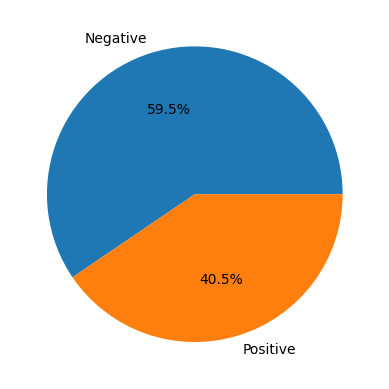

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

labels = ['Negative', 'Positive']
plt.pie(train_df['label'].value_counts(),autopct='%1.1f%%',labels=labels)
plt.show()

Cross check the raw data with the files in the traning directory. The data matches with the csv file.

In [12]:
images_true = list((pathlib.Path(dir_true).with_suffix('')).glob('*.jpg'))
image_count_true = len(images_true)
print("Number of images with cancer being detected:",image_count_true)

images_false = list((pathlib.Path(dir_false).with_suffix('')).glob('*.jpg'))
image_count_false = len(images_false)
print("Number of images with cancer not being detected:",image_count_false)

Number of images with cancer being detected: 89117
Number of images with cancer not being detected: 130908


In [13]:
#from sklearn.model_selection import train_test_split
#X_train, X_verify, y_train, y_verify = train_test_split(X, y, random_state=13, train_size=0.8)
#print(len(X_train), len(X_verify), len(y_train), len(y_verify))

Take some of the training images to be shown on the screen, the first set are positive images and the second set are negative images. 

In [14]:
import PIL
import PIL.TiffImagePlugin
from PIL import Image

Sample images with cancer being detected:


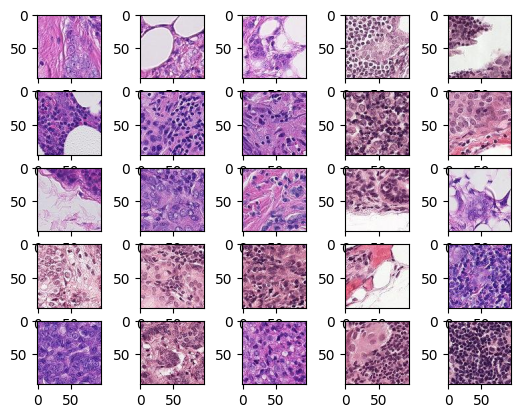

In [15]:
fig_width = 5
fig_height = 5
fig,ax = plt.subplots(fig_height,fig_width)

print("Sample images with cancer being detected:")
for i in range(fig_width * fig_height):
    with open(images_true[i], "rb") as f:
        img = Image.open(f)
        ax[i%fig_height][i//fig_width].imshow(img)

Sample images with cancer not being detected:


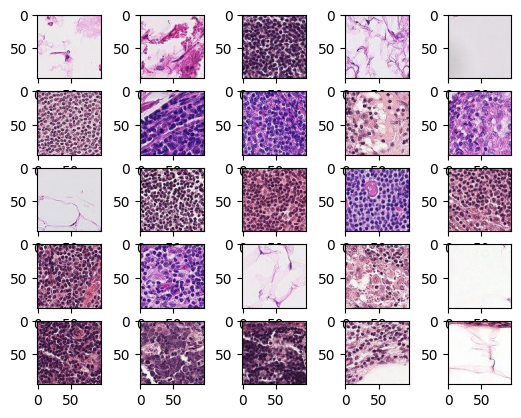

In [16]:
fig_width = 5
fig_height = 5
fig,ax = plt.subplots(fig_height,fig_width)
        
print("Sample images with cancer not being detected:")
for i in range(fig_width * fig_height):
    with open(images_false[i], "rb") as f:
        img = Image.open(f)
        ax[i%fig_height][i//fig_width].imshow(img)

To process the mimages, we need to know the size attibute of the images, it's (96,96) as shown below.

In [17]:
print(Image.open(images[0]).size)

(96, 96)


Generate then load the training image dataset with image_dataset_from_directory API from the directory. Split 20% from the dataset to be used for validation.

Confirm all training files are in place again.

In [18]:
print("image_count:",len(images), image_count)
list_ds = tf.data.Dataset.list_files(str(train_path/'*/*'), shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)

image_count: 220025 220025
Metal device set to: Apple M1


2023-02-15 12:32:21.469832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-15 12:32:21.469977: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
for f in list_ds.take(5):
    print(f.numpy())

b'hpcd/train/0/ccbe7a4e7eafcee0dadc418a1d3adb3be6a1665e.jpg'
b'hpcd/train/0/d2e11244c61790f1f6ccd23e092070df59af2ee9.jpg'
b'hpcd/train/1/7ca835262e61bab17c6edd5fed24b1f3802f7452.jpg'
b'hpcd/train/1/56e3e3b66d23fa31e4fbce892131a0010b728458.jpg'
b'hpcd/train/1/5454ba1f1053e0d9c768b9479eeb2342a1abba1f.jpg'


In [20]:
labels = train_df['label'].unique()
print(labels)

[0 1]


In [21]:
img_size = Image.open(images[0]).size
class_names = ['0', '1']
batch_size = 32
orig_train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  class_names = class_names,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)


Found 220025 files belonging to 2 classes.
Using 176020 files for training.


In [22]:
orig_val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  class_names = class_names,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 220025 files belonging to 2 classes.
Using 44005 files for validation.


Check the type of the dataset and the information of elements in the dataset.

In [23]:
print(orig_train_ds, "\n", orig_val_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> 
 <BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


It indicates that each batch includes 32 images, among which, each image is 96*96 colored with RGB

In [24]:
for image_batch, labels_batch in orig_train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 96, 96, 3)
(32,)


2023-02-15 12:32:35.827220: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## NN Model Architecture 
The high level architecture of the training network are referring to the tensorflow training material. On top of the referrd architecture, in this practice, several different modles with changing the hyper parameters such as different activation function and different loss funtion are tried to find the best one.
To have better performance, preloaded mecahnism is included.

In [25]:
from tensorflow.keras import layers

Preload the dataset to cache to accelarate the training.

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = orig_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = orig_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Try the model with different hyper parameters to get the best one, to reduce the time, the epochs for each parameters set is set to 5, it may not nbe very accurate.
GPU is enabled.

In [27]:
hyper_params = [
  {
    'num_classes':2,
    'activation':'relu',
    'loss':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  },
  {
    'num_classes':2,
    'activation':'sigmoid',
    'loss':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  },
  {
    'num_classes':2,
    'activation':'softmax',
    'loss':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  },
  {
    'num_classes':2,
    'activation':'relu',
    'loss':tf.keras.losses.MeanSquaredLogarithmicError()
  },
  {
    'num_classes':2,
    'activation':'sigmoid',
    'loss':tf.keras.losses.MeanSquaredLogarithmicError()
  },
  {
    'num_classes':2,
    'activation':'softmax',
    'loss':tf.keras.losses.MeanSquaredLogarithmicError()
  }
]

In [31]:
from tensorflow.keras.optimizers.legacy import Adam
opt = Adam()

best_model = None
best_param = None
best_result = 0
for p in hyper_params:
    print("Model params:",p)
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(img_size[0],img_size[1],3)),
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        #tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.Conv2D(64, 3, activation=p['activation']),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation=p['activation']),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation=p['activation']),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=p['activation']),
        tf.keras.layers.Dense(p['num_classes'])
    ])

    model.compile(
      opt,
      loss=p['loss'],
      metrics=['accuracy'])
    
    model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=5
    )
    
    metrics = model.get_metrics_result()
    acc = metrics['accuracy'].numpy() #- metrics['loss'].numpy()
    if acc > best_result:
        best_model = model
        best_param = p
        best_result = acc

Model params: {'num_classes': 2, 'activation': 'relu', 'loss': <keras.losses.SparseCategoricalCrossentropy object at 0x2c7f31a00>}
Epoch 1/5


2023-02-16 00:17:04.833637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.8100

2023-02-16 00:27:11.242017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 642s 117ms/step - loss: 0.4213 - accuracy: 0.8100 - val_loss: 0.3375 - val_accuracy: 0.8556
Epoch 2/5
5501/5501 [==============================] - 634s 115ms/step - loss: 0.3211 - accuracy: 0.8654 - val_loss: 0.2939 - val_accuracy: 0.8758
Epoch 3/5
5501/5501 [==============================] - 727s 132ms/step - loss: 0.2841 - accuracy: 0.8824 - val_loss: 0.2781 - val_accuracy: 0.8849
Epoch 4/5
5501/5501 [==============================] - 761s 138ms/step - loss: 0.2554 - accuracy: 0.8961 - val_loss: 0.2793 - val_accuracy: 0.8860
Epoch 5/5
5501/5501 [==============================] - 758s 138ms/step - loss: 0.2295 - accuracy: 0.9085 - val_loss: 0.2927 - val_accuracy: 0.8801
Model params: {'num_classes': 2, 'activation': 'sigmoid', 'loss': <keras.losses.SparseCategoricalCrossentropy object at 0x2c7f31a30>}
Epoch 1/5


2023-02-16 01:15:46.323881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - ETA: 0s - loss: 0.6819 - accuracy: 0.5928

2023-02-16 02:13:51.071250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 4435s 806ms/step - loss: 0.6819 - accuracy: 0.5928 - val_loss: 0.6744 - val_accuracy: 0.5976
Epoch 2/5
5501/5501 [==============================] - 7589s 1s/step - loss: 0.6777 - accuracy: 0.5936 - val_loss: 0.6744 - val_accuracy: 0.5976
Epoch 3/5
5501/5501 [==============================] - 605s 110ms/step - loss: 0.6777 - accuracy: 0.5936 - val_loss: 0.6744 - val_accuracy: 0.5976
Epoch 4/5
5501/5501 [==============================] - 9156s 2s/step - loss: 0.6777 - accuracy: 0.5936 - val_loss: 0.6744 - val_accuracy: 0.5976
Epoch 5/5
5501/5501 [==============================] - 7562s 1s/step - loss: 0.6777 - accuracy: 0.5936 - val_loss: 0.6744 - val_accuracy: 0.5976
Model params: {'num_classes': 2, 'activation': 'softmax', 'loss': <keras.losses.SparseCategoricalCrossentropy object at 0x2c7f31a60>}
Epoch 1/5


2023-02-16 09:24:54.511092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.5943

2023-02-16 09:35:56.084426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 703s 128ms/step - loss: 0.6754 - accuracy: 0.5943 - val_loss: 0.6745 - val_accuracy: 0.5976
Epoch 2/5
5501/5501 [==============================] - 735s 134ms/step - loss: 0.6753 - accuracy: 0.5943 - val_loss: 0.6745 - val_accuracy: 0.5976
Epoch 3/5
5501/5501 [==============================] - 789s 143ms/step - loss: 0.6753 - accuracy: 0.5943 - val_loss: 0.6744 - val_accuracy: 0.5976
Epoch 4/5
5501/5501 [==============================] - 703s 128ms/step - loss: 0.6753 - accuracy: 0.5943 - val_loss: 0.6744 - val_accuracy: 0.5976
Epoch 5/5
5501/5501 [==============================] - 720s 131ms/step - loss: 0.6753 - accuracy: 0.5943 - val_loss: 0.6744 - val_accuracy: 0.5976
Model params: {'num_classes': 2, 'activation': 'relu', 'loss': <keras.losses.MeanSquaredLogarithmicError object at 0x2c7f31a90>}
Epoch 1/5


2023-02-16 10:25:49.115750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.5943

2023-02-16 10:36:57.886270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 710s 128ms/step - loss: 0.1956 - accuracy: 0.5943 - val_loss: 0.1933 - val_accuracy: 0.5976
Epoch 2/5
5501/5501 [==============================] - 633s 115ms/step - loss: 0.1949 - accuracy: 0.5943 - val_loss: 0.1933 - val_accuracy: 0.5976
Epoch 3/5
5501/5501 [==============================] - 659s 120ms/step - loss: 0.1949 - accuracy: 0.5943 - val_loss: 0.1933 - val_accuracy: 0.5976
Epoch 4/5
5501/5501 [==============================] - 655s 119ms/step - loss: 0.1949 - accuracy: 0.5943 - val_loss: 0.1933 - val_accuracy: 0.5976
Epoch 5/5
5501/5501 [==============================] - 829s 151ms/step - loss: 0.1949 - accuracy: 0.5943 - val_loss: 0.1933 - val_accuracy: 0.5976
Model params: {'num_classes': 2, 'activation': 'sigmoid', 'loss': <keras.losses.MeanSquaredLogarithmicError object at 0x2c7f31ac0>}
Epoch 1/5


2023-02-16 11:23:51.455400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.4057

2023-02-16 11:35:29.673430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 733s 133ms/step - loss: 0.1949 - accuracy: 0.4057 - val_loss: 0.1933 - val_accuracy: 0.4024
Epoch 2/5
5501/5501 [==============================] - 711s 129ms/step - loss: 0.1949 - accuracy: 0.4057 - val_loss: 0.1933 - val_accuracy: 0.4024
Epoch 3/5
5501/5501 [==============================] - 712s 129ms/step - loss: 0.1949 - accuracy: 0.4057 - val_loss: 0.1933 - val_accuracy: 0.4024
Epoch 4/5
5501/5501 [==============================] - 643s 117ms/step - loss: 0.1949 - accuracy: 0.4057 - val_loss: 0.1933 - val_accuracy: 0.4024
Epoch 5/5
5501/5501 [==============================] - 682s 124ms/step - loss: 0.1949 - accuracy: 0.4057 - val_loss: 0.1933 - val_accuracy: 0.4024
Model params: {'num_classes': 2, 'activation': 'softmax', 'loss': <keras.losses.MeanSquaredLogarithmicError object at 0x2c7f31af0>}
Epoch 1/5


2023-02-16 12:21:53.217381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - ETA: 0s - loss: 0.1949 - accuracy: 0.4057

2023-02-16 13:48:17.297469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 7176s 1s/step - loss: 0.1949 - accuracy: 0.4057 - val_loss: 0.1933 - val_accuracy: 0.4024
Epoch 2/5
5501/5501 [==============================] - 10991s 2s/step - loss: 0.1949 - accuracy: 0.4057 - val_loss: 0.1933 - val_accuracy: 0.4024
Epoch 3/5
5501/5501 [==============================] - 714s 130ms/step - loss: 0.1949 - accuracy: 0.4057 - val_loss: 0.1933 - val_accuracy: 0.4024
Epoch 4/5
5501/5501 [==============================] - 815s 148ms/step - loss: 0.1949 - accuracy: 0.4057 - val_loss: 0.1933 - val_accuracy: 0.4024
Epoch 5/5
5501/5501 [==============================] - 817s 148ms/step - loss: 0.1949 - accuracy: 0.4057 - val_loss: 0.1933 - val_accuracy: 0.4024


Summary of the best model and the corresponding hyper-parameters.

In [32]:
model = best_model
model.summary()
model.get_metrics_result()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 random_flip_7 (RandomFlip)  (None, 96, 96, 3)         0         
                                                                 
 conv2d_21 (Conv2D)          (None, 94, 94, 64)        1792      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 47, 47, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 45, 45, 64)        36928     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 22, 22, 64)       0         
 g2D)                                                 

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.2926503>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.88008183>}

In [33]:
print("Parameter:", best_param)

Parameter: {'num_classes': 2, 'activation': 'relu', 'loss': <keras.losses.SparseCategoricalCrossentropy object at 0x2c7f31a00>}


To get better result, retrain the best model with more epochs(15) and early-stop callbacks.  The early-stop callbacks will cause the training to be stopped when the val_accuracy decreases in two continous rounds. With the early-stop mechanism, it can avoid significant overfitting problem.
To prevent overfitting further, the L2 regularity and drop-out were added initially, but the final result was very bad, so the two groups are removed from the final model.

The model includes the following layers:
1. Preprocessing (Rescale) and augument (Flip) layer
2. Output layer
3. 3 hidden CNN layer with 64*3 nodes per layer and 3 hidden pooling layer
4. Optimization algorithm: Adam
5. Activation function:relu
6. Other parameters: default value

In [34]:
from tensorflow.keras import regularizers
p = best_param
epochs = 15
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_size[0],img_size[1],3)),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    #tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.Conv2D(64, 3, activation=p['activation']),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation=p['activation']),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation=p['activation']),
    tf.keras.layers.MaxPooling2D(),
    

    tf.keras.layers.Flatten(),

    #Add L2 regulation and dropout layer to avoid overfitting
    #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
    #             activation='elu'),
    
    #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
    #             activation='elu'),
    #layers.Dropout(0.5),
    #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
    #             activation='elu'),
    #layers.Dropout(0.5),
    #layers.Dense(128, kernel_regularizer=regularizers.l2(0.0001),
    #             activation='elu'),
    #layers.Dropout(0.5),
    
    
    tf.keras.layers.Dense(128, activation=p['activation']),
    #tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(p['num_classes'])
])

model.compile(
    opt,
    loss=p['loss'],
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
)

Epoch 1/15


2023-02-16 18:03:47.468366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.7659

2023-02-16 18:14:55.287855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5501/5501 [==============================] - 1080s 196ms/step - loss: 0.4758 - accuracy: 0.7659 - val_loss: 0.4176 - val_accuracy: 0.8090
Epoch 2/15
5501/5501 [==============================] - 8224s 1s/step - loss: 0.3910 - accuracy: 0.8255 - val_loss: 0.3657 - val_accuracy: 0.8373
Epoch 3/15
5501/5501 [==============================] - 7288s 1s/step - loss: 0.3635 - accuracy: 0.8404 - val_loss: 0.3507 - val_accuracy: 0.8456
Epoch 4/15
5501/5501 [==============================] - 616s 112ms/step - loss: 0.3471 - accuracy: 0.8488 - val_loss: 0.3414 - val_accuracy: 0.8505
Epoch 5/15
5501/5501 [==============================] - 649s 118ms/step - loss: 0.3348 - accuracy: 0.8560 - val_loss: 0.3420 - val_accuracy: 0.8513
Epoch 6/15
5501/5501 [==============================] - 620s 113ms/step - loss: 0.3235 - accuracy: 0.8611 - val_loss: 0.3358 - val_accuracy: 0.8561
Epoch 7/15
5501/5501 [==============================] - 626s 114ms/step - loss: 0.3105 - accuracy: 0.8678 - val_loss: 0.3330 -

The training is stopped earlier when epoch=5. Check the history information of the training.

In [35]:
history = model.history.history
print(history.keys())
history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


{'loss': [0.47584375739097595,
  0.391026109457016,
  0.36354032158851624,
  0.34710752964019775,
  0.3348267376422882,
  0.323487788438797,
  0.3105084002017975,
  0.2982151508331299,
  0.2877076268196106],
 'accuracy': [0.7659072875976562,
  0.8254914283752441,
  0.8404386043548584,
  0.8487672209739685,
  0.8560447692871094,
  0.861140787601471,
  0.8678162097930908,
  0.8736791610717773,
  0.8783717751502991],
 'val_loss': [0.41760650277137756,
  0.3657293915748596,
  0.3506913483142853,
  0.3414153754711151,
  0.3419668972492218,
  0.3358469009399414,
  0.3330000638961792,
  0.3473849892616272,
  0.33972567319869995],
 'val_accuracy': [0.8090444207191467,
  0.8372685313224792,
  0.8456084728240967,
  0.850471556186676,
  0.8513351082801819,
  0.8561300039291382,
  0.8591523766517639,
  0.8549028635025024,
  0.8559482097625732]}

In [36]:
#The plot function referrs to the code from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
def plot_accuracy(history):
    plt.plot(history['accuracy'],'*-')
    plt.plot(history['val_accuracy'],"x-")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid()
    plt.show()
# summarize history for loss
def plot_loss(history):
    plt.plot(history['loss'],'*-')
    plt.plot(history['val_loss'],'x-')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid()
    plt.show()

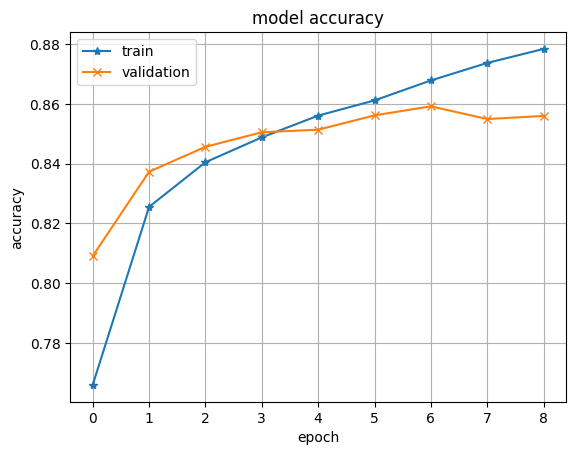

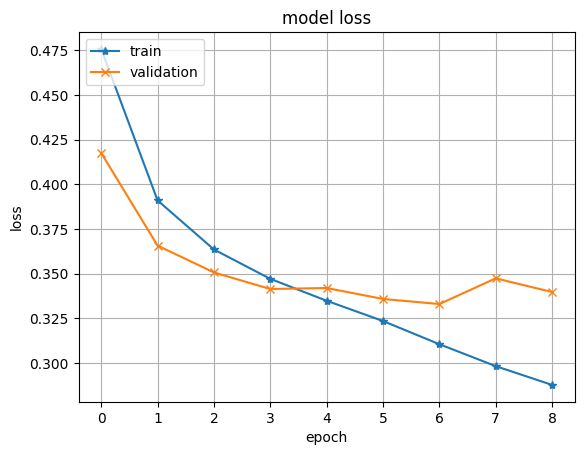

In [37]:
plot_accuracy(history)
plot_loss(history)

Refer to the tutorial, to make the probability more obvious, a softmax layer is added as the latest layer of the model.

## Test
Before testing, a softmax layer is added to the model to make the probability more obvious.
The test images are from the previously prepared test directory.
To make the result clearer, a pandas dataframe is created for the record.

Add softmax layer

In [38]:
model.add(tf.keras.layers.Softmax())

Load data and create the dataframe respectively.

In [39]:
test_files = np.array(os.listdir(test_dir))

In [40]:
test_df = pd.DataFrame(test_files, columns=['id'])
print(test_df)

                                                 id
0      1d72b9448e3eb6d1de8d8e6e94f48730f63bfde7.jpg
1      674d6f5b6a0a6180223f68e3114abf0a140b2225.jpg
2      4cd8ebe1187041a7a2c1e4f74c75816b4796270a.jpg
3      887f9067fd159db8f41b7b7f01bbaa1bf407f859.jpg
4      66458d57360ec266c19e51bf10c1d26f517b1981.jpg
...                                             ...
57453  e746318251601a3cf3cdde41bcf978633f2bd32c.jpg
57454  98abc394daaf1bf3fca880b06dc1f2ac93b5a7d5.jpg
57455  ebc6371413f800533d2808f2f11e900cc4729e64.jpg
57456  c1171891e0a0c358c9345d84f4b7811a0073fe4f.jpg
57457  007993203e329bafda75acffc0d0439c930b380c.jpg

[57458 rows x 1 columns]


In [41]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator() #rescale is embedded in the model, no pre-rescaling
test_ds = test_datagen.flow_from_dataframe(
    test_df,
    test_dir,
    class_mode=None,
    shuffle= False,
    x_col = 'id',
    y_col = None,
    target_size = img_size
)

Found 57458 validated image filenames.


Predict. The result of the prediction is the probability of each class_name per record. The probability is mapped to the class_names then put to the dataframe at the end. 

In [42]:
pred = model.predict(test_ds)

2023-02-16 23:45:39.837737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1796/1796 [==============================] - 32s 18ms/step


In [43]:
print(pred.shape)
print(pred)

(57458, 2)
[[0.01026632 0.98973376]
 [0.905111   0.09488893]
 [0.27623335 0.7237667 ]
 ...
 [0.98078394 0.01921604]
 [0.5313784  0.4686217 ]
 [0.90522593 0.09477412]]


In [44]:
test_df = test_df.applymap(lambda x: os.path.splitext(x)[0])

In [45]:
pred = pd.DataFrame(pred)
test_df['label'] = pred.apply(np.argmax, axis=1)

In [46]:
test_df

,id,label
0,1d72b9448e3eb6d1de8d8e6e94f48730f63bfde7,1
1,674d6f5b6a0a6180223f68e3114abf0a140b2225,0
2,4cd8ebe1187041a7a2c1e4f74c75816b4796270a,1
3,887f9067fd159db8f41b7b7f01bbaa1bf407f859,1
4,66458d57360ec266c19e51bf10c1d26f517b1981,0
...,...,...
57453,e746318251601a3cf3cdde41bcf978633f2bd32c,1
57454,98abc394daaf1bf3fca880b06dc1f2ac93b5a7d5,0
57455,ebc6371413f800533d2808f2f11e900cc4729e64,0
57456,c1171891e0a0c358c9345d84f4b7811a0073fe4f,0


In [47]:
test_df.to_csv('submission.csv',index=False)

In [48]:
test_df['label'].value_counts()

0    36782
1    20676
Name: label, dtype: int64

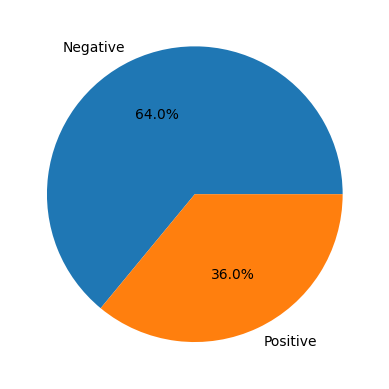

In [49]:
labels = ['Negative', 'Positive']
plt.pie(test_df['label'].value_counts(),autopct='%1.1f%%',labels=labels)
plt.show()

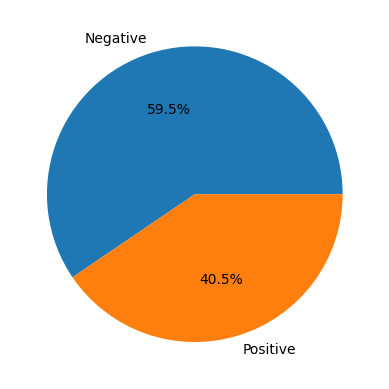

In [50]:
plt.pie(train_df['label'].value_counts(),autopct='%1.1f%%',labels=labels)
plt.show()

## Conclusion and Analysis
From the statistics information of training data, the percentage of negative and positive are 60% and 40% respectively. The statistics of the predicted testing data indicates the percentage of negative and positive are 66% and 34% respectively.
As a rough estimation, there's 6% gap between the distribution of the prediction and the real distribution, which means the accuracy of the prediction(testing) is less than 90% (1-6/60), considering there are also some false positive and false negative, the accuracy of the prediction could be around 75% to 80%.
There are some improvements can be applied to get better result.
1. Use tiff format directly.
2. Fine tune with trying more different hyper-parameters 
3. Add rotation and other more image augumentation (it does not work in my environment however)
4. Enhance the network